In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt, matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

# Evaluating genome clusters.

## Overview

Here we evaluate the genome clusters obtained by pair-wise comparisons of MAGs. A total of 401 MAGs binned using a minimum contig length of 2kb, with at least 50% estimated completeness and at most 5% estimated contamination were clustered using Mummer. The distance between two genomes was calculated as 1-(average nucleotide identity) and genomes were clustered at max distance 0.05 (i.e. 95% ANI).

The genome coverage cutoff (i.e. the percentage of the smaller genome in a pair-wise comparison that has to be covered by alignments) was evaluated at 50%, 75%, 90% and 95%.

In [3]:
def add_taxonomy_columns(df):
    taxdict = {"kingdom": [], "phylum": [], "class": [], "order": [], "family": [], "genus": [], "species": []}
    rank_letters = {"k": "kingdom", "p": "phylum", "c": "class", "o": "order", "f": "family", "g": "genus", "s": "species"}
    ranks = ["kingdom","phylum","class","order","family","genus","species"]
    for i, t in enumerate(df.Taxonomy):
        try: 
            results = t.split(";")
        except AttributeError:
            for rank in ranks:
                taxdict[rank].append("Unclassified")
            continue
        for j, a in enumerate(results):
            rank = a.split("_")[0]
            name = a.replace("{}__".format(rank),"").replace(" (root)","").replace("_"," ")
            taxdict[rank_letters[rank]].append(name)
        for rank in ranks[j+1:]:
            taxdict[rank].append("Unclassified.{}".format(name))

    return pd.merge(df,pd.DataFrame(taxdict,index=df.index)[ranks], left_index=True, right_index=True)

In [4]:
def calculate_coherence(mags):
    taxres = genome_stats.loc[mags,["kingdom","phylum","class","order","family","genus","species"]]
    coherent_rank = "species"
    ranks = ["kingdom","phylum","class","order","family","genus","species"]
    for i in range(len(ranks)):
        rank = ranks[i]
        if len(taxres[rank].unique()) == 1: 
            coherent_rank = rank
        else:
            return ranks[i-1]
    return coherent_rank

In [151]:
overlaps = ["50","75","90","95"]

Read distance matrix.

In [5]:
fasta_names = pd.read_table("data/mummer/2k/fasta_names.tsv", header=None, index_col=0)
dist_mat = pd.read_table("data/mummer/2k/dist_matrix.tsv", header=None)
dist_mat.index = fasta_names.index
dist_mat.columns = fasta_names.index

Read the genome cluster file

In [152]:
clusters = {}
for cov in overlaps:
    clusters[cov] = pd.read_table("data/mummer/2k/{}cov/genome_clusters.tsv".format(cov), index_col=0, header=None, names=["cluster{}".format(cov),"genome"])

Read genome stats

In [150]:
genome_stats = pd.read_table("data/genome_stats.tab", index_col=0)
genome_stats = add_taxonomy_columns(genome_stats)
genome_stats = genome_stats.assign(Genome_size_Mbp=pd.Series(genome_stats["Genome size (bp)"].div(1000000),index=genome_stats.index))

Merge genome stats and cluster definitions.

In [153]:
genome_clust_stats = genome_stats.loc[genome_stats.name.isin(fasta_names.index)]
genome_clust_stats.reset_index(inplace=True)
for cov in overlaps:
    genome_clust_stats = pd.merge(genome_clust_stats,clusters[cov].reset_index(), left_on="taxa", right_on="genome")
    genome_clust_stats.drop("genome", axis=1, inplace=True)
genome_clust_stats.set_index("taxa", inplace=True)

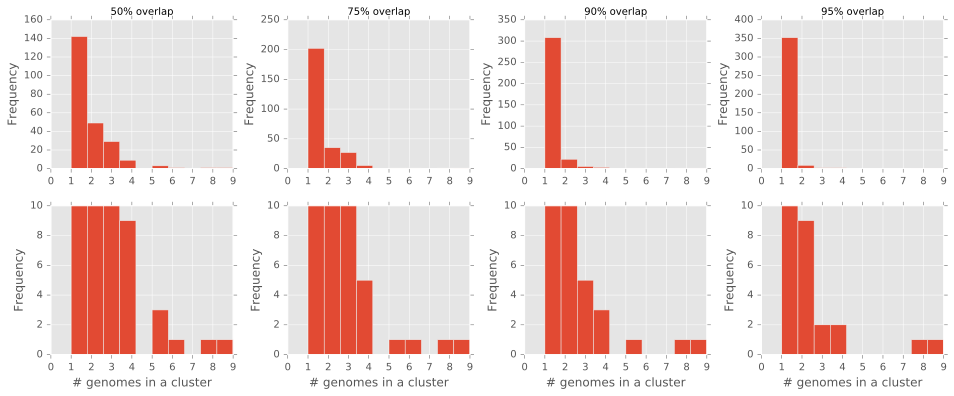

In [184]:
fig, axes = plt.subplots(ncols=len(overlaps), nrows=2, figsize=(16,6))
for j in [0,1]:
    row_axis = axes[j]
    for i, cov in enumerate(overlaps):
        axis = row_axis[i]
        ax = genome_clust_stats.groupby("cluster{}".format(cov)).count()["# genomes"].plot(kind="hist", ax=axis)
        if j==0:
            ax.set_title("{}% overlap".format(cov), fontsize=10)
        else:
            ax.set_ylim(0,10)
            ax.set_xlabel("# genomes in a cluster")
plt.subplots_adjust(hspace=0.25, wspace=0.3)
plt.savefig("figures/genomes_per_cluster.png", dpi=300, bbox_inches="tight")

## Check spread of genome sizes for clusters

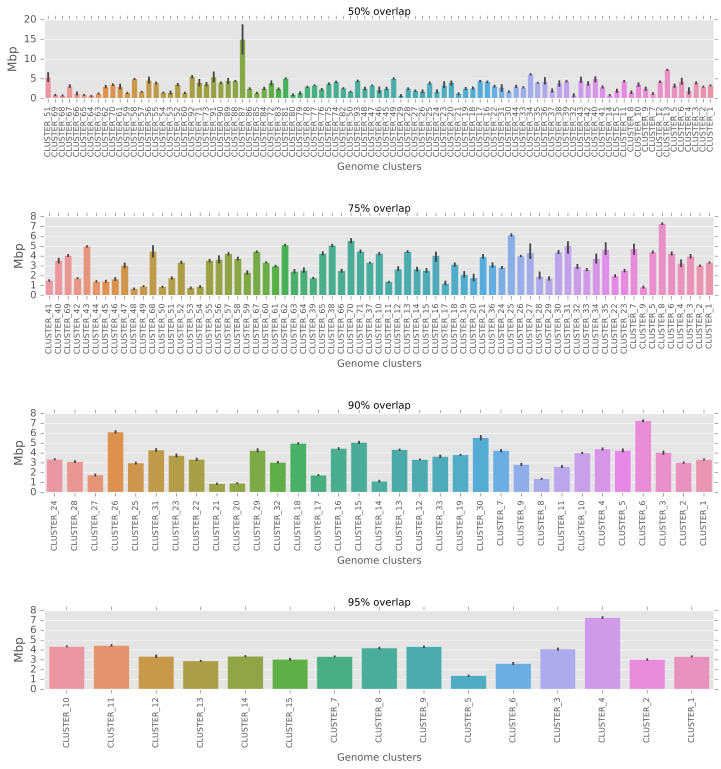

In [155]:
fig, axes = plt.subplots(ncols=1, nrows=len(overlaps), figsize=(12,12))

for i, cov in enumerate(overlaps):
    axis = axes[i]
    clust_counts = genome_clust_stats.groupby("cluster{}".format(cov)).count()["# genomes"]
    multi_clusters = clust_counts.loc[clust_counts>1].index
    clust_order = clust_counts.loc[multi_clusters].sort_values().index
    ax = sns.barplot(data=genome_clust_stats.loc[genome_clust_stats["cluster{}".format(cov)].isin(multi_clusters)],order=clust_order,x="cluster{}".format(cov), y="Genome_size_Mbp", ax=axis)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=8);
    ax.set_ylabel("Mbp")
    ax.set_title("{}% overlap".format(cov), fontsize=10)
    ax.set_xlabel("Genome clusters", fontsize=10)
plt.subplots_adjust(hspace=1.5)
plt.savefig("figures/genome_clusters_sizes.png", dpi=300, bbox_inches="tight")

In [43]:
genome_clust_stats.loc[genome_clust_stats.cluster50=="CLUSTER_87"]

name   Marker lineage  \
taxa                                                                          
Old_saline.038.2k                        Old_saline.038.2k  Prokaryote (-1)   
Old_saline_planktonic.078.2k  Old_saline_planktonic.078.2k  Prokaryote (-1)   

                              # genomes  # markers  # marker sets  \
taxa                                                                
Old_saline.038.2k                  5656         56             24   
Old_saline_planktonic.078.2k       5656         56             24   

                              Completeness  Contamination  \
taxa                                                        
Old_saline.038.2k                    100.0           0.52   
Old_saline_planktonic.078.2k          87.5           0.00   

                              Strain heterogeneity  Genome size (bp)  \
taxa                                                                   
Old_saline.038.2k                              0.0          11418620   
Old_saline_planktonic.078.2k                   0.0          18634675   

                              # ambiguous bases     ...              phylum  \
taxa                                                ...                       
Old_saline.038.2k                             0     ...       Bacteroidetes   
Old_saline_planktonic.078.2k                  0     ...       Bacteroidetes   

                                         class               order  \
taxa                                                                 
Old_saline.038.2k             Sphingobacteriia  Sphingobacteriales   
Old_saline_planktonic.078.2k  Sphingobacteriia  Sphingobacteriales   

                                           family       genus  \
taxa                                                            
Old_saline.038.2k             Sphingobacteriaceae  Pedobacter   
Old_saline_planktonic.078.2k  Sphingobacteriaceae  Pedobacter   

                                              species  Genome_size_Mbp  \
taxa                                                                     
Old_saline.038.2k             Unclassified.Pedobacter        11.418620   
Old_saline_planktonic.078.2k  Unclassified.Pedobacter        18.634675   

                               cluster50    cluster75    cluster90  
taxa                                                                
Old_saline.038.2k             CLUSTER_87  CLUSTER_241  CLUSTER_277  
Old_saline_planktonic.078.2k  CLUSTER_87  CLUSTER_257  CLUSTER_309  

[2 rows x 43 columns]

**Summary**

Most genome clusters have a low spread of genome sizes.

## Taxonomic congruence of clusters and links between assemblies

Make a graph of assemblies, with edges being the genome distance of MAGs in the same genome cluster.

In [60]:
def analyze_clusters(cluster_df, dist_mat):
    # To measure phylogenetic coherence of clusters, calculate fraction overlapping ranks per cluster
    taxcoherence = {}
    g = nx.MultiGraph()
    added = {}
    for cluster in cluster_df.index.unique():
        mags = cluster_df.loc[cluster,"genome"]
        internal_dist = dist_mat.loc[mags,mags].max().max()
        # Clusters are sorted by size, so if we reach a cluster with only one mag, stop
        if type(mags) == str: break
        taxcoherence[cluster] = calculate_coherence(mags)
        for mag in mags:
            assembly = mag.split(".")[0]
            for mag2 in mags:
                if mag==mag2: continue
                assembly2 = mag2.split(".")[0]
                try:
                    added["{}|{}".format(sorted([mag,mag2])[0],sorted([mag,mag2])[1])]
                    continue
                except KeyError:
                    pass

                dist = dist_mat.loc[mag,mag2]
                g.add_edge(assembly, assembly2, distance=dist)
                added["{}|{}".format(sorted([mag,mag2])[0],sorted([mag,mag2])[1])] = 1
    return g, taxcoherence

In [126]:
def get_mags_per_assembly(cluster_df):
    assembly_mag_nums = {}
    for cluster in cluster_df.index.unique():
        mags = cluster_df.loc[cluster,"genome"]
        if type(mags) == str:
            mags = [mags]
        for mag in mags:
            assembly = mag.split(".")[0]
            try:
                assembly_mag_nums[assembly]+=1
            except KeyError:
                assembly_mag_nums[assembly] = 1
    return assembly_mag_nums    

In [156]:
graphs = {}
taxco = {}
for cov in overlaps:
    g, taxcoherence = analyze_clusters(clusters[cov], dist_mat)
    graphs[cov] = g
    taxco[cov] = taxcoherence

### Taxonomic congruence

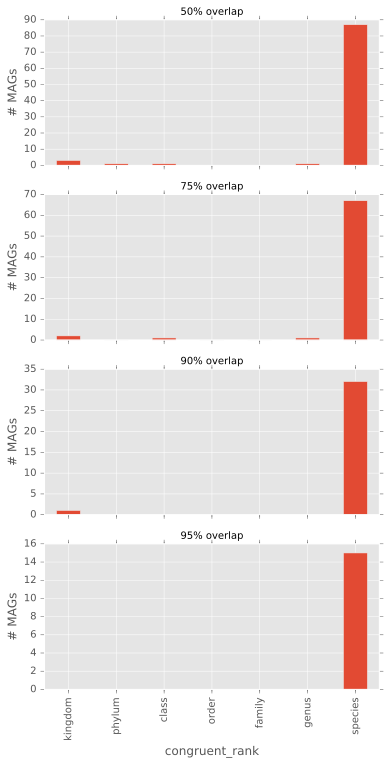

In [157]:
fig, axes = plt.subplots(ncols=1, nrows=len(overlaps), figsize=(6,12), sharex=True)
for i, cov in enumerate(overlaps):
    axis = axes[i]
    taxcoherence = taxco[cov]
    taxcodf = pd.DataFrame(taxcoherence, index=["congruent_rank"]).T
    ax = taxcodf.reset_index().groupby("congruent_rank").count().loc[["kingdom","phylum","class","order","family","genus","species"]].plot(kind="bar", legend=None, ax=axis)
    ax.set_ylabel("# MAGs")
    ax.set_title("{}% overlap".format(cov), fontsize=10)
#plt.subplots_adjust(hspace=1)
plt.savefig("figures/genome_clusters_congruence_ranks.png", dpi=300, bbox_inches="tight")

** Summary**

The absolute majority of clusters are coherent down to the species level. The discrepancy at kingdom level is still evident at 90% overlap but is resolved at 95% overlap.

### Clusters with discrepant taxonomies

In [159]:
discrepant_clusters = pd.DataFrame()

taxres = {}
for cov in overlaps:
    discrepant_mags = []
    taxcoherence = taxco[cov]
    taxcodf = pd.DataFrame(taxcoherence, index=["congruent_rank"]).T
    for cluster in list(taxcodf.loc[taxcodf["congruent_rank"]!="species"].index):
        discrepant_mags += list(clusters[cov].loc[cluster,"genome"].values)
    taxres[cov] = genome_clust_stats.loc[discrepant_mags,["cluster{}".format(cov),"Genome_size_Mbp","Completeness","kingdom","phylum","class","order","family","genus","species"]]

In [97]:
taxres["50"]

cluster50  Genome_size_Mbp  Completeness  \
taxa                                                                            
Modern_marine_glass_biofilm.030.2k  CLUSTER_29         0.872613         83.33   
Undefined_mixed_planktonic.002.2k   CLUSTER_29         0.537173         51.52   
Modern_marine.098.2k                CLUSTER_29         0.910219         79.17   
MMS_A.017.2k                        CLUSTER_55         3.852516         66.20   
Modern_marine_planktonic.020.2k     CLUSTER_55         4.091780         58.10   
Modern_marine_planktonic.030.2k     CLUSTER_58         4.963110         62.50   
Modern_marine.015.2k                CLUSTER_58         5.009028        100.00   
Modern_marine.093.2k                CLUSTER_64         0.658324         79.17   
Modern_marine_glass_biofilm.048.2k  CLUSTER_64         0.711968         87.50   
OSL_B.003.2k                        CLUSTER_84         2.760747        100.00   
Old_saline_planktonic.012.2k        CLUSTER_84         2.377501         93.98   
Undefined_mixed_planktonic.103.2k   CLUSTER_93         4.402184         55.30   
Old_saline_planktonic.081.2k        CLUSTER_93         4.586677         67.71   

                                     kingdom                 phylum  \
taxa                                                                  
Modern_marine_glass_biofilm.030.2k  Bacteria            Chloroflexi   
Undefined_mixed_planktonic.002.2k   Bacteria  Unclassified.Bacteria   
Modern_marine.098.2k                Bacteria            Chloroflexi   
MMS_A.017.2k                        Bacteria         Proteobacteria   
Modern_marine_planktonic.020.2k     Bacteria         Proteobacteria   
Modern_marine_planktonic.030.2k     Bacteria  Unclassified.Bacteria   
Modern_marine.015.2k                Bacteria        Ignavibacteriae   
Modern_marine.093.2k                Bacteria            Chloroflexi   
Modern_marine_glass_biofilm.048.2k  Bacteria  Unclassified.Bacteria   
OSL_B.003.2k                        Bacteria         Proteobacteria   
Old_saline_planktonic.012.2k        Bacteria         Proteobacteria   
Undefined_mixed_planktonic.103.2k   Bacteria         Proteobacteria   
Old_saline_planktonic.081.2k        Bacteria         Proteobacteria   

                                                    class  \
taxa                                                        
Modern_marine_glass_biofilm.030.2k      Dehalococcoidetes   
Undefined_mixed_planktonic.002.2k   Unclassified.Bacteria   
Modern_marine.098.2k                    Dehalococcoidetes   
MMS_A.017.2k                           Betaproteobacteria   
Modern_marine_planktonic.020.2k       Alphaproteobacteria   
Modern_marine_planktonic.030.2k     Unclassified.Bacteria   
Modern_marine.015.2k                       Ignavibacteria   
Modern_marine.093.2k                    Dehalococcoidetes   
Modern_marine_glass_biofilm.048.2k  Unclassified.Bacteria   
OSL_B.003.2k                           Betaproteobacteria   
Old_saline_planktonic.012.2k           Betaproteobacteria   
Undefined_mixed_planktonic.103.2k     Gammaproteobacteria   
Old_saline_planktonic.081.2k          Gammaproteobacteria   

                                                              order  \
taxa                                                                  
Modern_marine_glass_biofilm.030.2k   Unclassified.Dehalococcoidetes   
Undefined_mixed_planktonic.002.2k             Unclassified.Bacteria   
Modern_marine.098.2k                 Unclassified.Dehalococcoidetes   
MMS_A.017.2k                                        Burkholderiales   
Modern_marine_planktonic.020.2k                     Caulobacterales   
Modern_marine_planktonic.030.2k               Unclassified.Bacteria   
Modern_marine.015.2k                              Ignavibacteriales   
Modern_marine.093.2k                 Unclassified.Dehalococcoidetes   
Modern_marine_glass_biofilm.048.2k            Unclassified.Bacteria   
OSL_B.003.2k                        Unclassified.Betaprote

In [98]:
taxres["75"]

cluster75  Genome_size_Mbp  Completeness  \
taxa                                                                            
Modern_marine_planktonic.030.2k     CLUSTER_43         4.963110         62.50   
Modern_marine.015.2k                CLUSTER_43         5.009028        100.00   
Modern_marine_glass_biofilm.048.2k  CLUSTER_48         0.711968         87.50   
Modern_marine.093.2k                CLUSTER_48         0.658324         79.17   
OSL_B.003.2k                        CLUSTER_64         2.760747        100.00   
Old_saline_planktonic.012.2k        CLUSTER_64         2.377501         93.98   
Undefined_mixed_planktonic.103.2k   CLUSTER_71         4.402184         55.30   
Old_saline_planktonic.081.2k        CLUSTER_71         4.586677         67.71   

                                     kingdom                 phylum  \
taxa                                                                  
Modern_marine_planktonic.030.2k     Bacteria  Unclassified.Bacteria   
Modern_marine.015.2k                Bacteria        Ignavibacteriae   
Modern_marine_glass_biofilm.048.2k  Bacteria  Unclassified.Bacteria   
Modern_marine.093.2k                Bacteria            Chloroflexi   
OSL_B.003.2k                        Bacteria         Proteobacteria   
Old_saline_planktonic.012.2k        Bacteria         Proteobacteria   
Undefined_mixed_planktonic.103.2k   Bacteria         Proteobacteria   
Old_saline_planktonic.081.2k        Bacteria         Proteobacteria   

                                                    class  \
taxa                                                        
Modern_marine_planktonic.030.2k     Unclassified.Bacteria   
Modern_marine.015.2k                       Ignavibacteria   
Modern_marine_glass_biofilm.048.2k  Unclassified.Bacteria   
Modern_marine.093.2k                    Dehalococcoidetes   
OSL_B.003.2k                           Betaproteobacteria   
Old_saline_planktonic.012.2k           Betaproteobacteria   
Undefined_mixed_planktonic.103.2k     Gammaproteobacteria   
Old_saline_planktonic.081.2k          Gammaproteobacteria   

                                                              order  \
taxa                                                                  
Modern_marine_planktonic.030.2k               Unclassified.Bacteria   
Modern_marine.015.2k                              Ignavibacteriales   
Modern_marine_glass_biofilm.048.2k            Unclassified.Bacteria   
Modern_marine.093.2k                 Unclassified.Dehalococcoidetes   
OSL_B.003.2k                        Unclassified.Betaproteobacteria   
Old_saline_planktonic.012.2k                      Hydrogenophilales   
Undefined_mixed_planktonic.103.2k                   Alteromonadales   
Old_saline_planktonic.081.2k                        Alteromonadales   

                                                             family  \
taxa                                                                  
Modern_marine_planktonic.030.2k               Unclassified.Bacteria   
Modern_marine.015.2k                 Unclassified.Ignavibacteriales   
Modern_marine_glass_biofilm.048.2k            Unclassified.Bacteria   
Modern_marine.093.2k                 Unclassified.Dehalococcoidetes   
OSL_B.003.2k                        Unclassified.Betaproteobacteria   
Old_saline_planktonic.012.2k                     Hydrogenophilaceae   
Undefined_mixed_planktonic.103.2k                    Shewanellaceae   
Old_saline_planktonic.081.2k                         Shewanellaceae   

                                                              genus  \
taxa                                                                  
Modern_marine_planktonic.030.2k               Unclassified.Bacteria   
Modern_marine.015.2k                 Unclassified.Ignavibacteriales   
Modern_marine_glass_biofilm.048.2k            Unclassified.Bacteria   
Modern_marine.093.2k                 Unclassified.Dehalococcoidetes   
OSL_B.003.2k                        Unclassified.Betapro

In [160]:
taxres["90"]

cluster90  Genome_size_Mbp  Completeness  \
taxa                                                                         
Modern_marine.015.2k             CLUSTER_18         5.009028         100.0   
Modern_marine_planktonic.030.2k  CLUSTER_18         4.963110          62.5   

                                  kingdom                 phylum  \
taxa                                                               
Modern_marine.015.2k             Bacteria        Ignavibacteriae   
Modern_marine_planktonic.030.2k  Bacteria  Unclassified.Bacteria   

                                                 class                  order  \
taxa                                                                            
Modern_marine.015.2k                    Ignavibacteria      Ignavibacteriales   
Modern_marine_planktonic.030.2k  Unclassified.Bacteria  Unclassified.Bacteria   

                                                         family  \
taxa                                                              
Modern_marine.015.2k             Unclassified.Ignavibacteriales   
Modern_marine_planktonic.030.2k           Unclassified.Bacteria   

                                                          genus  \
taxa                                                              
Modern_marine.015.2k             Unclassified.Ignavibacteriales   
Modern_marine_planktonic.030.2k           Unclassified.Bacteria   

                                                        species  
taxa                                                             
Modern_marine.015.2k             Unclassified.Ignavibacteriales  
Modern_marine_planktonic.030.2k           Unclassified.Bacteria

**Summary**

*50% coverage threshold:*

CLUSTER_55 seems to have discrepant taxonomies at the class level (Alpha-/Betaproteobacteria) but in all other cases the discrepancy is the result of unclassified MAG(s).

*75% coverage threshold:*

Already at this level, the discrepancy for CLUSTER_55 is resolved.

*90% coverage threshold:*

At this level, the only remaining discrebant cluster is the Ignavibacteriae and Unclassified.Bacteria MAGs.

*95% coverage threshold:*

At this level all clusters are resolved down to species level.

### Overlaps between assemblies

Calculate heatmap data.

In [101]:
def make_edge_counts(g):
    edge_counts = pd.DataFrame(columns=sorted(g.nodes()), index=sorted(g.nodes()))
    for i in range(len(g.nodes())):
        for j in range(len(g.nodes())):
            node1 = sorted(g.nodes())[i]
            node2 = sorted(g.nodes())[j]
            if node1 == node2:
                edge_counts[node1][node2] = -1
                continue
            try: 
                dists = [g[node1][node2][e]["distance"] for e in g[node1][node2]]
            except KeyError:
                continue
            edge_counts[node1][node2] = len(dists)
            edge_counts[node2][node1] = len(dists)
    return edge_counts

In [162]:
edge_counts = {}
for cov in overlaps:
    edge_counts[cov] = make_edge_counts(graphs[cov])

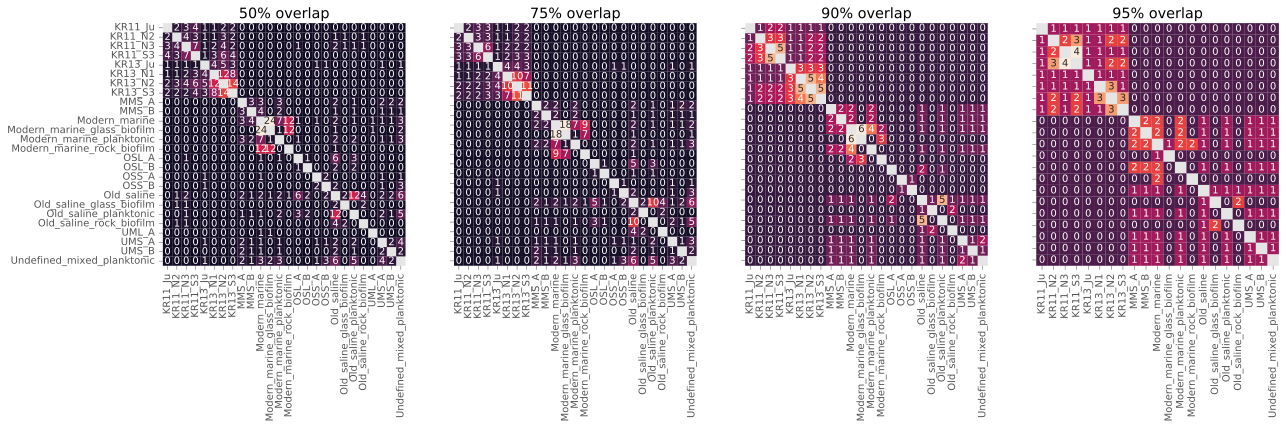

In [163]:
fig, axes = plt.subplots(ncols=len(overlaps), nrows=1, figsize=(20,16))
for i, cov in enumerate(overlaps):
    edges = edge_counts[cov]
    ticklocs = [x+0.5 for x in range(0,len(edges))]
    axis = axes[i]
    mask = edges<1
    ax = sns.heatmap(edges.fillna(0), square=True, mask=mask, annot=True, cbar=False, ax=axis)
    ax.axes.xaxis.set_ticks(ticklocs)
    ax.axes.xaxis.set_ticklabels(ax.axes.yaxis.get_ticklabels(), fontsize=10)
    ax.set_title("{}% overlap".format(cov))
    if i>0:
        ax.axes.yaxis.set_ticklabels("")
plt.savefig("figures/genome_clusters_assembly_heatmap.png", dpi=300, bbox_inches="tight")

**Summary**

Assemblies with most samples in common, and sharing similar environmental characteristics, also share the highest number of MAGs in genome clusters.

Plot the graph of assembly links.

In [129]:
color_dict = {"Modern_marine": "red", "Modern_marine_rock_biofilm": "red", "Modern_marine_glass_biofilm": "red",
              "Modern_marine_planktonic": "red", "MML_A": "red", "MML_B": "red",
              "MMS_A": "red", "MMS_B": "red","MMBR": "red", "MMBG": "red",
              
              "Old_saline": "lightblue", "Old_saline_glass_biofilm": "lightblue",  "Old_saline_rock_biofilm": "lightblue", 
              "Old_saline_planktonic": "lightblue",
              "OSL_A": "lightblue", "OSL_B": "lightblue",
              "OSS_A": "lightblue", "OSS_B": "lightblue",  "OSBR": "lightblue", "OSBG": "lightblue",
              
              "Undefined_mixed": "green", "Undefined_mixed_planktonic": "green",
              "UMS_A":"green", "UMS_B": "green", "UML_A": "green", "UML_B": "green", 
             
              "KR11_Ju": "grey", "KR11_N2": "grey", "KR11_N3": "grey", "KR11_S3": "grey", "KR13_Ju": "grey",
              "KR13_N1": "grey", "KR13_N2": "grey", "KR13_S3": "grey", "KR46_Ju": "grey"}

Draw a graph where each assembly is a node and each edge is a pair of MAGs from the two assemblies seen in the same genome cluster. Edges where MAGs have a genome distance of > 0.01 (i.e. are less than 99% similar) are dashed while MAGs with a genome distance of <= 0.01 (i.e. are >=99% similar) are solid.

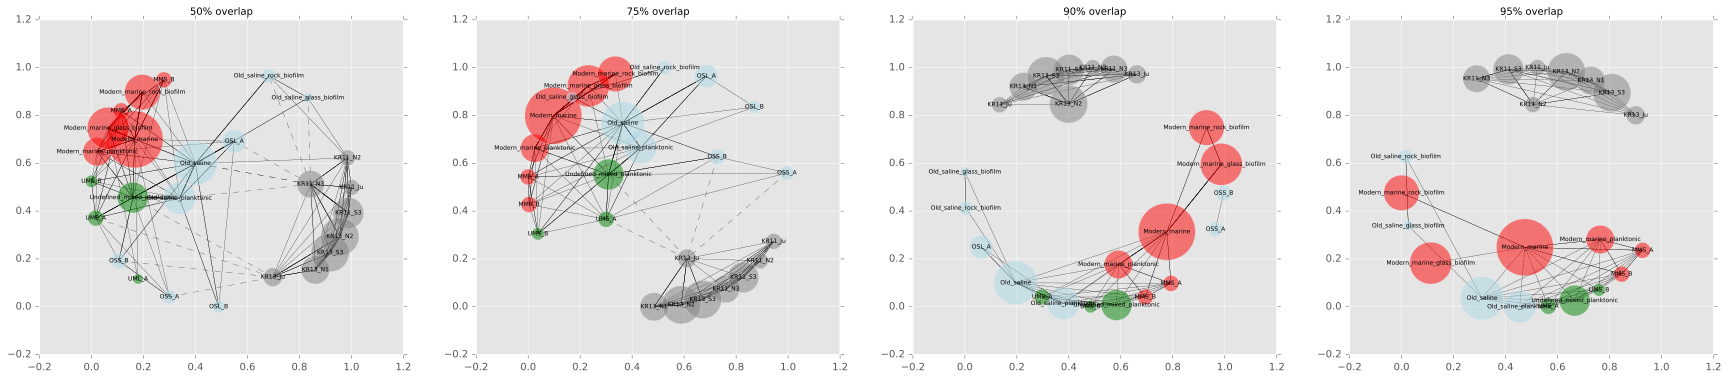

In [164]:
fig, axes = plt.subplots(ncols=len(overlaps), nrows=1, figsize=(30,6))
for i, cov in enumerate(overlaps):
    axis = axes[i]
    g = graphs[cov]
    assembly_mag_nums = get_mags_per_assembly(clusters[cov])
    pos = nx.spring_layout(g, k=0.4, iterations=1000)

    node_sizes = []
    node_colors = []
    node_labels = []
    for node in g.nodes():
        node_sizes.append(assembly_mag_nums[node]*50)
        node_labels.append(node)
        node_colors.append(color_dict[node])
    elarge=[(u,v) for (u,v,d) in g.edges(data=True) if d['distance'] > 0.01]
    ezero=[(u,v) for (u,v,d) in g.edges(data=True) if d['distance'] <= 0.01]
    nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_colors, linewidths=0.5, alpha=0.5, ax=axis)
    labels = nx.draw_networkx_labels(g, pos, font_size=6, ax=axis)
    nx.draw_networkx_edges(g, pos, edgelist=elarge, style="dashed",width=0.25, ax=axis)
    nx.draw_networkx_edges(g, pos, edgelist=ezero, style="solid",width=0.25, ax=axis)
    axis.set_title("{}% overlap".format(cov), fontsize=10)
fig.savefig("figures/genome_clusters_assembly_graph.png", dpi=300, bbox_inches="tight")

**Summary**

The highest number of links are seen among the Modern Marine, Old saline and among the 'KR' samples respectively. The Undefined mixed assembles appear to share MAGs with both the Modern Marine and Old saline assemblies. Interestingly, the 'KR' samples form tight clusters with links mostly to the Old saline assemblies, however with larger genome distances. However, at 90% required overlap the KR assemblies all form a separate cluster.

## Selecting representative genomes

Best representatives are chosen for each genome with criteria in the following order:
- Maximum completeness
- Minimum contamination
- Maximum N50 length
- Maximum number of predicted genes

In [140]:
def write_reps(cluster_df, genome_stats, outfile, clust_col):
    cluster_reps = {}
    for cluster in cluster_df.index.unique():
        res = genome_stats.loc[genome_clust_stats[clust_col]==cluster]
        filtered = res.copy(deep=True)
        for crit in ["Completeness","Contamination","N50 (contigs)","# predicted genes"]:
            if crit == "Contamination":
                val = filtered.min()[crit]
            else:
                val = filtered.max()[crit]
            filtered = filtered.loc[res[crit]==val]
            if len(filtered) == 1:
                #print("{}: Broke tie on {}".format(cluster,crit))
                cluster_reps[cluster] = filtered["name"].values[0]
                break
        if len(filtered)>1: 
            print("{}: Tie not broken!".format(cluster))
    genome_reps_stats = genome_stats.loc[genome_clust_stats["name"].isin(cluster_reps.values()),["name",clust_col,"Genome size (bp)","GC","Completeness","Contamination","# predicted genes","kingdom","phylum","class","order","family","genus","species"]]
    genome_reps_stats.set_index("name", inplace=True)
    genome_reps_stats.sort_index().to_csv(outfile, sep="\t")

In [165]:
for cov in overlaps:
    write_reps(clusters[cov], genome_clust_stats, "results/genome_representatives.2k.{}cov.tab".format(cov), "cluster{}".format(cov))